# REDD Dataset Exploration

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib as plt
import datetime

*The following cell sets up the figure size for hi-res screens*

**Must be run after the first figure is plot for the first time**

In [2]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['figure.dpi'] = 200

## Import dataset

In [3]:
DATASET = Path("Datasets/REDD/low_freq/")
TARGET_HOUSE = "house_3"

In [4]:
house_dir = DATASET / TARGET_HOUSE
labels_file = house_dir / "labels.dat"
channel_files = list(house_dir.glob('channel_*.dat'))

** Available Appliances **

In [5]:
labels = pd.read_table(labels_file, sep = ' ', header = None, index_col = 0)
labels

,1
0,
1,mains
2,mains
3,outlets_unknown
4,outlets_unknown
5,lighting
6,electronics
7,refrigerator
8,disposal
9,dishwaser


In [6]:
channels = None
for channel_file in channel_files:
    channel_n = channel_file.stem.split('_')[1]
    channel = pd.read_table(channel_file, sep = ' ', names = ['' + labels[1][int(channel_n)] + '@' + channel_n], index_col = 0, parse_dates=True, date_parser=lambda t: datetime.datetime.fromtimestamp(int(t)))
    if channels is None:
        channels = channel
    else:
        channels = pd.concat([channels, channel], axis=1, join='inner')


## Compare appliances over full dataset
Add applicance type to be plotted in the `TARGET_CHANNEL_NAMES` list

In [7]:
TARGET_CHANNEL_NAMES = ['mains', 'lighting', 'washer_dryer', 'refrigerator']

In [8]:
selected_channels = labels[labels[1].isin(TARGET_CHANNEL_NAMES)]
target_channels = (selected_channels[1] + '@' + selected_channels.index.astype(str)).tolist()
target_channels


['mains@1',
 'mains@2',
 'lighting@5',
 'refrigerator@7',
 'lighting@11',
 'washer_dryer@13',
 'washer_dryer@14',
 'lighting@15',
 'lighting@17',
 'lighting@19']

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

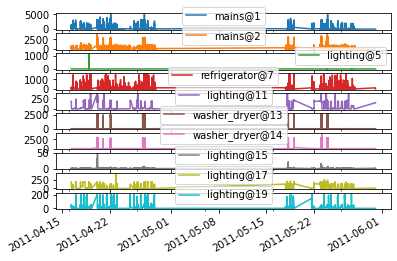

In [9]:
channels.plot(y = target_channels, subplots = True)

## Compare different timespans of same appliance
Set applicance identifier `<appliance_label@channel_number>` to be plotted in the `TARGET_CHANNEL_NAME` variable

Add the `(<begin_date>, <end_date>)` tuples delimiting the to-be-compared timespans in the `INTERVALS` list

In [10]:
TARGET_CHANNEL_NAME = 'refrigerator@7'
INTERVALS = [
    ('2011-04-18 01:00:00', '2011-04-18 02:00:00'), 
    ('2011-04-18 02:00:00', '2011-04-18 03:00:00')
]

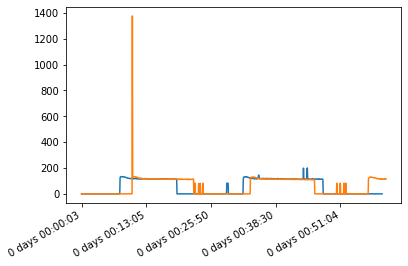

In [11]:
timeseries = [(datetime.datetime.strptime(b, '%Y-%m-%d %H:%M:%S'), channels['refrigerator@7'].loc[b:e]) for (b,e) in INTERVALS]
ax = None
for (b, ts) in timeseries:
    ts.index = ts.index - b
    if ax is None:
        ax = ts.plot()
    else:
        ts.plot(ax=ax)